# Preliminary analysis ECG simulated datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Attempting to load model from: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/results_ecg_simulation_new/ecg_physionet_level0_iid/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/model.pth
Attempting to load metadata from: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/results_ecg_simulation_new/ecg_physionet_level0_iid/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv
Attempting to load client test data from: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/data/ecg_physionet/splits/ecg_physionet_level0_iid/client_0_test.pt
Temporary model.config created at: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/bin/model.config
Using device: cpu


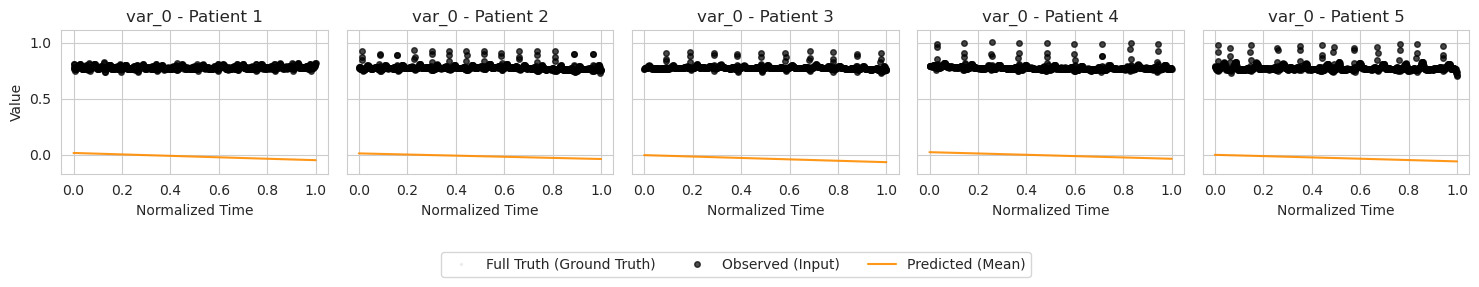

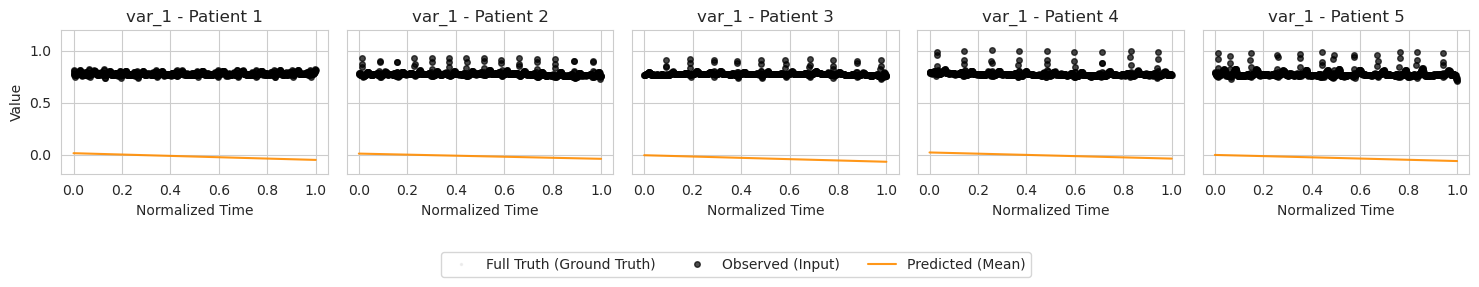

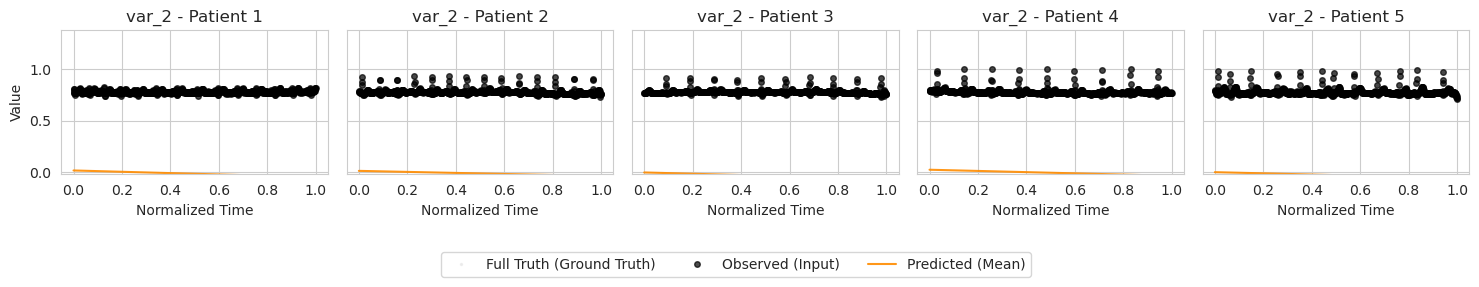

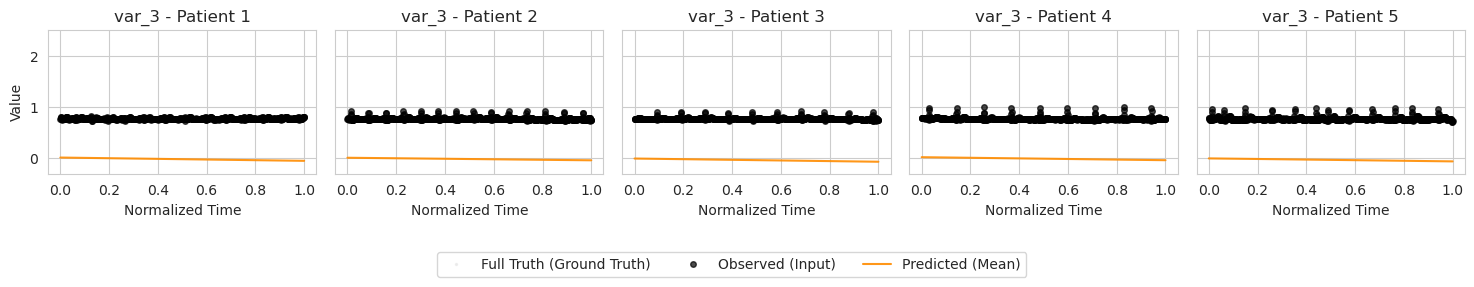

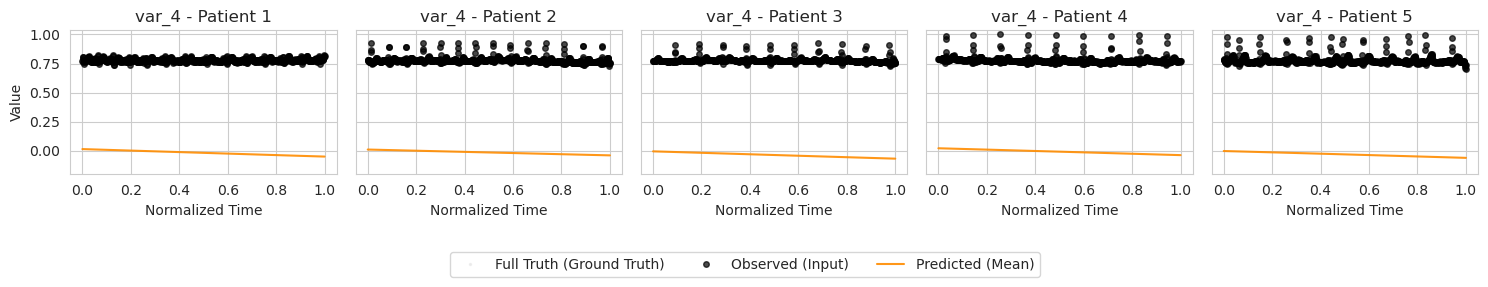

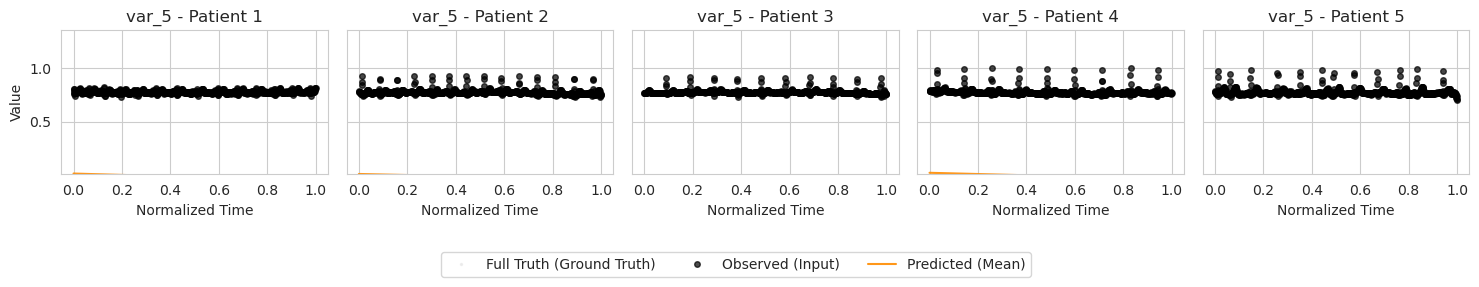

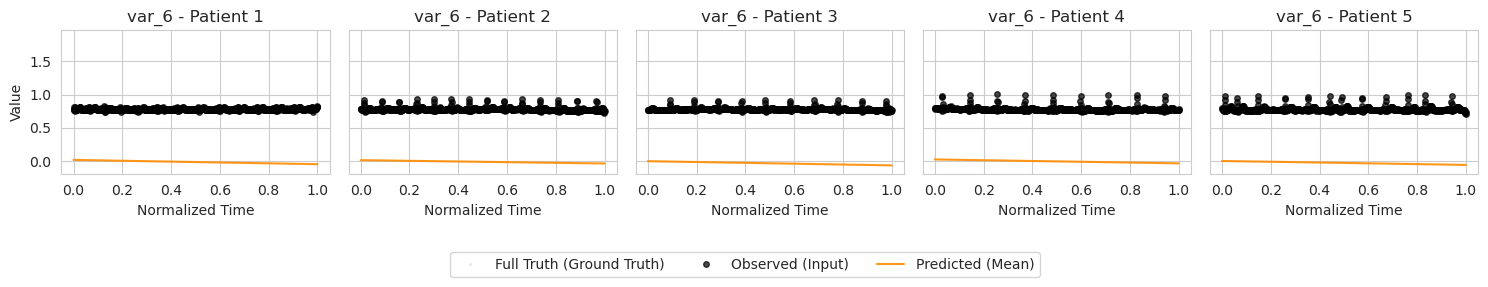

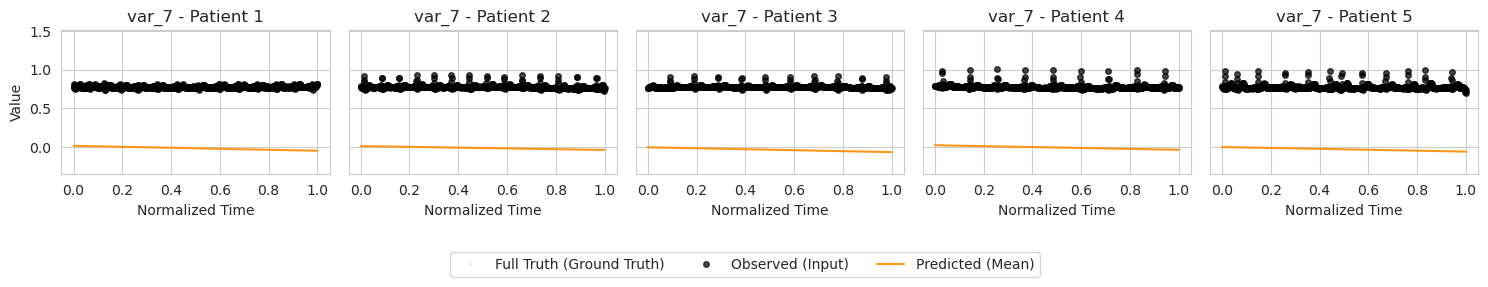

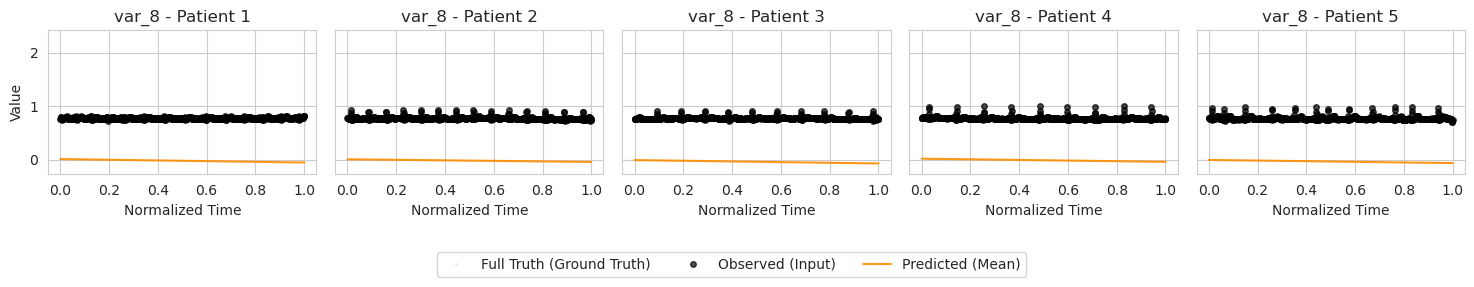

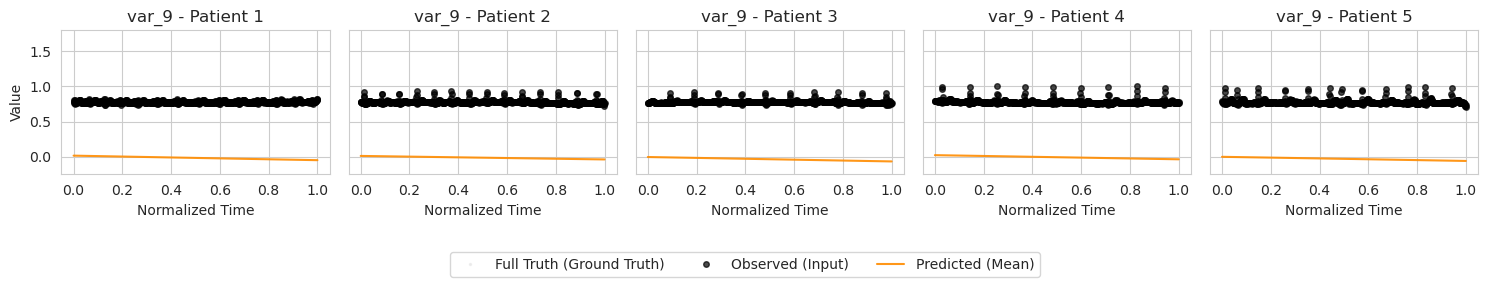

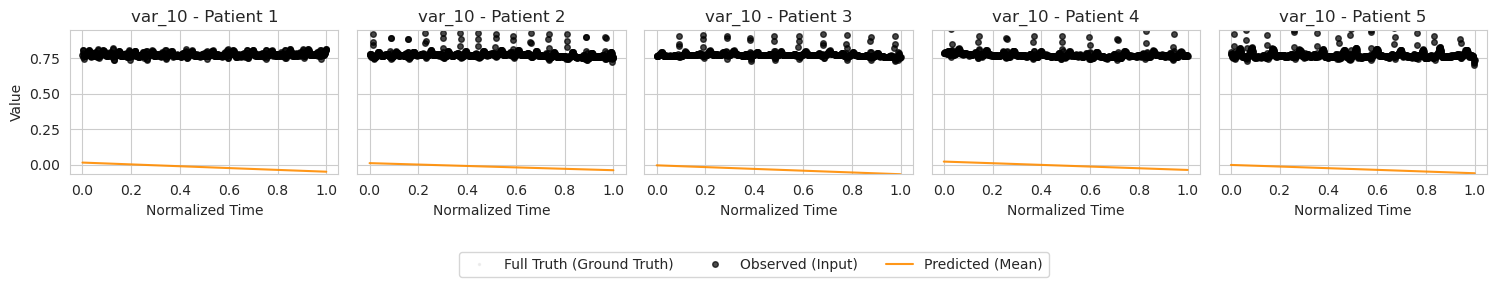

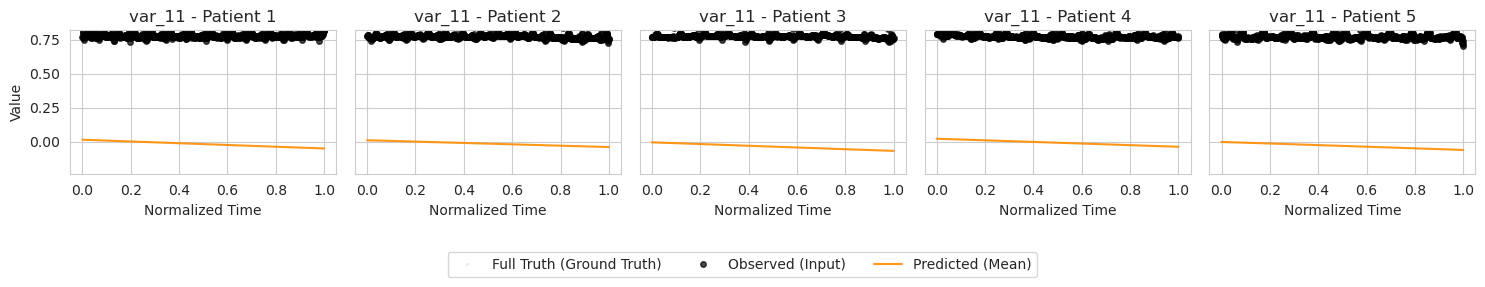


Finished plotting predictions vs. truth.
Cleaned up temporary model.config: /gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf/bin/model.config


In [27]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from types import SimpleNamespace
from torch.utils.data import DataLoader
import json # Import json to read model_config or results files

# --- Adjust ROOT_DIR to your actual project path ---
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf' # <--- IMPORTANT: Adjust this path!

# Add the bin directory to sys.path so Python can find your modules
sys.path.append(os.path.join(ROOT_DIR, 'bin'))
# Change working directory to 'bin' as some scripts expect it (e.g., model.config loading)
# This is crucial for flower.model_config.get_model_config("model.config") to work correctly
os.chdir(os.path.join(ROOT_DIR, 'bin'))

# --- Auto-reload modules in Jupyter for convenience during development ---
%matplotlib inline
%load_ext autoreload
%autoreload 2

# --- Import custom modules ---
# Ensure these imports are consistent with your file structure
from flower.task import Net # Contains Net() model architecture and data loading utils
from lib.physionet import variable_time_collate_fn, get_data_min_max # For PhysioNet/ECG data
from lib import utils # Contains utilities like inf_generator, linspace_vector
from lib.plot import plot_trajectories # For plotting time series
from flower.model_config import get_model_config # To get the model config parameters

# --- Define specific run and data paths ---
# Base results directory (from your ecg_simulation.config)
RESULTS_BASE_DIR = os.path.join(ROOT_DIR, 'results_ecg_simulation_new')
# Base data directory (from your ecg_simulation.config)
DATA_BASE_DIR = os.path.join(ROOT_DIR, 'data', 'ecg_physionet', 'splits') # Your data_folder path

# Specific run parameters for the model you want to load
DATASET_NAME = 'ecg_physionet_level0_iid'
AGGREGATION = 'FedODE'
SERVER_ROUNDS = 10
REPLICATE = 1
ALPHA = 0.0
LR = 0.001
BATCH_SIZE = 32
CLIPPING = 'False' # 'False' from config, not boolean False here for path consistency
LRDECAY = 1.0
LOCAL_EPOCHS = 10
DECAY_ONSET = 15

# Construct the full path to the federated_outputs directory for this run
FED_OUTPUTS_DIR = os.path.join(
    RESULTS_BASE_DIR,
    DATASET_NAME,
    'federated_training',
    AGGREGATION,
    f'{SERVER_ROUNDS}_rounds',
    f'rep_{REPLICATE}-alpha_{ALPHA}-lr_{LR}-batchsize_{BATCH_SIZE}_clipping_{CLIPPING}_lrdecay_{LRDECAY}_localepochs_{LOCAL_EPOCHS}_decayonset_{DECAY_ONSET}_alpha_{ALPHA}',
    'federated_outputs'
)

# Paths to the model weights and the meta.csv for this specific run
MODEL_PATH = os.path.join(FED_OUTPUTS_DIR, 'model.pth')
META_PATH = os.path.join(FED_OUTPUTS_DIR, 'meta.csv') # Path to the metadata file

# We need test data for one of the clients (e.g., client_0)
CLIENT_ID_FOR_PLOTTING = 0 # Choose client 0 or 1
CLIENT_TEST_DATA_PATH = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{CLIENT_ID_FOR_PLOTTING}_test.pt')
CLIENT_DATA_MIN_PATH = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{CLIENT_ID_FOR_PLOTTING}_data_min.pt')
CLIENT_DATA_MAX_PATH = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'client_{CLIENT_ID_FOR_PLOTTING}_data_max.pt')
ATTR_NAMES_PATH = os.path.join(DATA_BASE_DIR, DATASET_NAME, f'attr_names.pt')


# --- Verification of paths ---
print(f"Attempting to load model from: {MODEL_PATH}")
print(f"Attempting to load metadata from: {META_PATH}")
print(f"Attempting to load client test data from: {CLIENT_TEST_DATA_PATH}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model weights file not found at: {MODEL_PATH}")
if not os.path.exists(META_PATH):
    raise FileNotFoundError(f"Metadata file not found at: {META_PATH}")
if not os.path.exists(CLIENT_TEST_DATA_PATH):
    raise FileNotFoundError(f"Client test data file not found at: {CLIENT_TEST_DATA_PATH}")

# --- IMPORTANT: Dynamically create a temporary model.config in the 'bin' directory ---
# This ensures Net() is instantiated with the exact parameters used during training.
temp_model_config_path = os.path.join(ROOT_DIR, 'bin', 'model.config')

# Read the meta.csv content
# The meta.csv has a header row and then a single row of values.
# We need to transform this into the key,value\nkey,value... format expected by get_model_config
with open(META_PATH, 'r') as f:
    lines = f.readlines()
header_line = lines[0].strip() # e.g., "id,dataset_name,data_folder,lr,..."
values_line = lines[1].strip() # e.g., "ecg_physionet_level5_temporal,ecg_physionet_level5_temporal,.,0.001,..."

# Split header and values
keys = header_line.split(',')
values = values_line.split(',')

# Write to a temporary model.config file in the 'bin' directory
with open(temp_model_config_path, 'w') as f:
    for i in range(len(keys)):
        # Ensure values are written as strings, mimicking the Nextflow config generation
        f.write(f"{keys[i].strip()},{values[i].strip()}\n")

print(f"Temporary model.config created at: {temp_model_config_path}")

# --- Set device (CPU or GPU) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Instantiate the model with the correct configuration ---
# Net() will now read the dynamically created model.config in the current working directory ('bin')
model = Net()
# Load state_dict, mapping to CPU if necessary (e.g., if trained on GPU but plotting on CPU)
loaded_state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(loaded_state_dict, strict=True) # strict=True ensures exact match
model.to(DEVICE) # Move model to the selected device
model.eval() # Set model to evaluation mode (disables dropout, batch norm updates, etc.)

# --- Load data for plotting ---
test_dataset_raw = torch.load(CLIENT_TEST_DATA_PATH, weights_only=False)
data_min = torch.load(CLIENT_DATA_MIN_PATH, weights_only=False)
data_max = torch.load(CLIENT_DATA_MAX_PATH, weights_only=False)

# Attributes names for plotting titles (e.g., 'var_0', 'var_1', or actual lead names)
if os.path.exists(ATTR_NAMES_PATH):
    attr_names_filtered = torch.load(ATTR_NAMES_PATH, weights_only=False)
else:
    # Fallback if attr_names.pt isn't specific to this dataset level
    # Assuming input_dim = 12 leads from ecg_simulation.config
    attr_names_filtered = np.array([f"var_{i}" for i in range(12)])

# Define args object for variable_time_collate_fn (mimics Nextflow params)
plot_args = SimpleNamespace()
plot_args.sample_tp = 0.0 # Sample all available time points for plotting
plot_args.cut_tp = None
plot_args.extrap = False # Assuming interpolation for visualization here

# Create DataLoader for a subset of the test data for plotting
NUM_PLOTTING_SAMPLES = 5 # How many individual patient ECGs to plot
NUM_LEADS_TO_PLOT = 12 # How many ECG leads (dimensions) to plot

# Select a small subset of test_dataset_raw for plotting
plotting_data_subset = test_dataset_raw[:NUM_PLOTTING_SAMPLES]

plot_dataloader = DataLoader(
    plotting_data_subset,
    batch_size=NUM_PLOTTING_SAMPLES, # Process all plotting samples in one batch
    shuffle=False,
    collate_fn=lambda batch: variable_time_collate_fn(
        batch, plot_args, DEVICE, data_type="test",
        data_min=data_min, data_max=data_max
    )
)

# Get the batch for plotting
plot_dataloader_iter = utils.inf_generator(plot_dataloader)
plot_batch_dict = utils.get_next_batch(plot_dataloader_iter)


# --- Prepare data for prediction and plotting ---
# Data that the model observes (input to encoder)
observed_data = plot_batch_dict["observed_data"]
observed_time_steps = plot_batch_dict["observed_tp"]
observed_mask = plot_batch_dict["observed_mask"]

# Ground truth data for comparison (target for reconstruction)
full_truth_data = plot_batch_dict["data_to_predict"]
full_truth_time_steps = plot_batch_dict["tp_to_predict"]
full_truth_mask = plot_batch_dict["mask_predicted_data"]

# Generate dense time steps for smooth predicted trajectories
# This is usually done to make the ODE integration output smooth
time_steps_to_predict_smooth = utils.linspace_vector(
    full_truth_time_steps[0], full_truth_time_steps[-1], 100
).to(DEVICE)

# --- Make predictions ---
with torch.no_grad(): # Disable gradient calculations for inference
    # reconstructions: [n_traj_samples, n_batch, n_timepoints, n_dims]
    # info: dict containing latent_traj, first_point, etc.
    reconstructions, info = model.get_reconstruction(
        time_steps_to_predict_smooth,
        observed_data,
        observed_time_steps,
        mask=observed_mask,
        n_traj_samples=10 # Use more samples for a better mean/std estimate
    )

# Get the mean prediction across samples from z0
# reconstructions_mean: [n_batch, n_timepoints_smooth, n_dims]
reconstructions_mean = reconstructions.mean(dim=0)
# Get the standard deviation across samples from z0 (for uncertainty, if needed)
reconstructions_std = reconstructions.std(dim=0)


# --- Plotting ---
sns.set_style("whitegrid")

# Iterate through each ECG lead (dimension)
for dim_to_show in range(min(NUM_LEADS_TO_PLOT, attr_names_filtered.shape[0])):
    lead_name = attr_names_filtered[dim_to_show]

    # Create a figure for each lead, showing multiple patient samples
    fig, axes = plt.subplots(1, NUM_PLOTTING_SAMPLES, figsize=(3 * NUM_PLOTTING_SAMPLES, 2.5), sharey=True)
    # Ensure axes is an array even for single subplot
    if NUM_PLOTTING_SAMPLES == 1:
        axes = [axes]

    # Determine global Y-limits for consistent scaling across patients for this lead
    # Use full_truth_data to define limits based on actual range, not just observed
    current_dim_data = full_truth_data[:, :, dim_to_show].cpu().numpy()
    current_dim_recons = reconstructions_mean[:, :, dim_to_show].cpu().numpy() # Use mean for range

    max_y = max(current_dim_data.max(), current_dim_recons.max()) if current_dim_data.size > 0 else 0.0
    min_y = min(current_dim_data.min(), current_dim_recons.min()) if current_dim_data.size > 0 else 0.0
    y_range = max_y - min_y
    y_padding = y_range * 0.1 if y_range > 0 else 0.1 # Add 10% padding, handle zero range
    
    for traj_id in range(NUM_PLOTTING_SAMPLES):
        ax = axes[traj_id] # Get the current subplot axis

        # 1. Plot all original data points (truth, even if observed or not) - for context
        #    We manually mask here to only plot points that actually existed in the ground truth
        plot_trajectories(
            ax,
            full_truth_data[traj_id].unsqueeze(0), # Pass single trajectory
            full_truth_time_steps,
            mask=full_truth_mask[traj_id].unsqueeze(0),
            min_y=min_y, max_y=max_y,
            marker='.', linestyle='', markersize=3, alpha=0.3,
            color='lightgray', label='Full Truth (Ground Truth)'
        )

        # 2. Plot the *observed* data points used as input to the model (subset of truth)
        plot_trajectories(
            ax,
            observed_data[traj_id].unsqueeze(0), # Pass single trajectory
            observed_time_steps,
            mask=observed_mask[traj_id].unsqueeze(0),
            min_y=min_y, max_y=max_y,
            marker='o', linestyle='', markersize=4, alpha=0.7,
            color='black', add_to_plot=True, label='Observed (Input)'
        )
        
        # 3. Plot the mean reconstructed/predicted trajectory
        plot_trajectories(
            ax,
            reconstructions_mean[traj_id].unsqueeze(0), # Pass single trajectory
            time_steps_to_predict_smooth,
            min_y=min_y, max_y=max_y,
            title=f"{lead_name} - Patient {traj_id+1}", # Title per subplot
            marker='', linestyle='-', linewidth=1.5, alpha=0.9,
            color='darkorange', add_to_plot=True, label='Predicted (Mean)'
        )
        
        # 4. (Optional) Plot uncertainty/standard deviation of reconstructions
        # from lib.plot import plot_std # Make sure this is imported if you use it
        # plot_std(
        #     ax,
        #     reconstructions_mean[traj_id].unsqueeze(0),
        #     reconstructions_std[traj_id].unsqueeze(0),
        #     time_steps_to_predict_smooth,
        #     alpha=0.2, color='darkorange', add_to_plot=True
        # )

        ax.set_ylim(min_y - y_padding, max_y + y_padding)
        ax.set_xlabel('Normalized Time')
        if traj_id == 0:
            ax.set_ylabel('Value')
        else:
            ax.set_ylabel('') # Only label y-axis on the first subplot
            ax.tick_params(axis='y', labelleft=False) # Hide y-axis labels for other subplots

    # Add a single legend for the entire figure at the bottom
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate labels if any (e.g., from full_truth if plotted multiple times)
    unique_labels = dict(zip(labels, handles))
    fig.legend(unique_labels.values(), unique_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)

    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for the legend
    plt.show()

print("\nFinished plotting predictions vs. truth.")

# --- Cleanup temporary model.config ---
try:
    if os.path.exists(temp_model_config_path):
        os.remove(temp_model_config_path)
        print(f"Cleaned up temporary model.config: {temp_model_config_path}")
except Exception as e:
    print(f"Error during cleanup of temporary model.config: {e}")

In [19]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/fl4tsf'
BIN_DIR = f'{ROOT_DIR}/bin'
DATA_DIR = f'{ROOT_DIR}/data'
import sys
sys.path.append(ROOT_DIR)
sys.path.append(BIN_DIR)
import glob
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from torch.utils.data import DataLoader
from lib import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from lib.plot import plot_trajectories
from lib.plot_utils import read_loss_file, get_summary_lambdas, plot_client_loss
import json

prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None
rec_layers = 3
gen_layers = 3
units = 500
gru_units = 500
latents = 30
rec_dims = 40

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None

res_folder = "results_ecg_simulation_new"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Centralized training

In [5]:
####################################
#     Centralized training results
####################################
result_json_centralized = glob.glob(f"../{res_folder}/**/centralized_training/**/**/**/loss_per_epoch.csv", recursive=True)
result_json_centralized = list(set(result_json_centralized))
result_json_centralized

df_centralized = pd.DataFrame()
for file in result_json_centralized:
    df_centralized_temp = pd.read_csv(file)
    df_centralized_temp['run_id'] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_centralized_temp["dataset_name"] = file.split("/")[-5]
    df_centralized = pd.concat([df_centralized, df_centralized_temp])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized["dataset_name"] = df_centralized["dataset_name"].str.replace("ecg_physionet_", "")
df_centralized

# get the min train and val loss for each run_id
df_centralized_min = df_centralized.groupby('dataset_name').agg({'train_loss': 'min', 'val_loss': 'min'}).reset_index()

# create a column called loss and another called type that takes eithe train or val based on whether the value comes from train_loss or val_loss
df_centralized['loss'] = df_centralized['train_loss']
df_centralized['type'] = 'train'
df_centralized_val = df_centralized.copy()
df_centralized_val['loss'] = df_centralized['val_loss']
df_centralized_val['type'] = 'val'
df_centralized = pd.concat([df_centralized, df_centralized_val])
df_centralized = df_centralized.reset_index(drop=True)
df_centralized["client"] = "centralized_training"

# order by dataset_name
df_centralized = df_centralized.sort_values(by=["dataset_name"]).reset_index(drop=True)


<Figure size 1000x300 with 0 Axes>

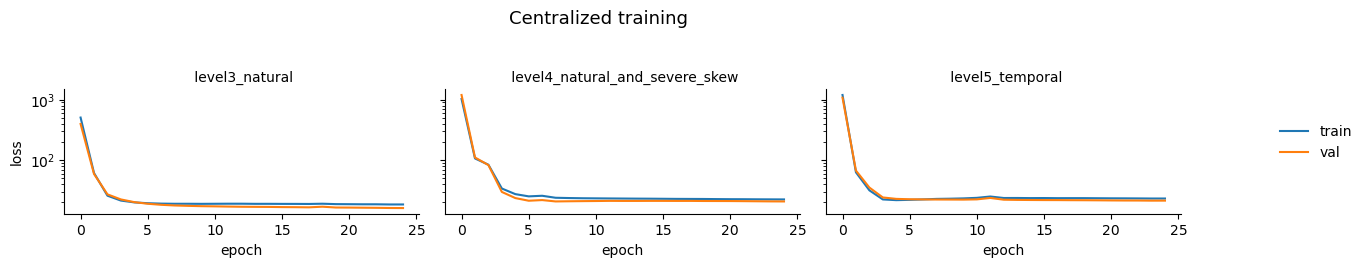

In [6]:
# fig size
plt.figure(figsize=(10, 3))


# Create FacetGrid
g = sns.FacetGrid(
    df_centralized,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='epoch',
    y='loss',
    hue='type',
    markers=True,
    palette='tab10'
)

# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" {col_name}")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Centralized training", fontsize=13, y=1.05)

# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log
plt.yscale('log')


plt.tight_layout()
plt.show()

# Playing with the visualization of the results

In [62]:
# # Load dataset
# dataset_name = "ecg_physionet_level3_natural"
# c0 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{dataset_name}/client_0_test.pt", weights_only=False)
# #c1 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/ecg_physionet_level0_iid/client_1_train.pt", weights_only=False)
# # attr_names = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/attr_names.pt", weights_only=False)
# # attr_names_filtered = attr_names
# # create list of string from 0 to 11
# attr_names_filtered = np.array([f"var_{i}" for i in range(12)])
# # load model weights 
# model = Net()
# w_cen = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_ecg_simulation_new/{dataset_name}/centralized_training/25_epochs/lr_0.001-batchsize_32_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
# # w_local = torch.load("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/local_training/client_0/10_epochs/10_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
# model.load_state_dict(w_cen)
# # #model.load_state_dict(w_local)

In [63]:
# n_traj_to_show = 3
# filtered_dataset = c0[10:40]
# data_min, data_max = get_data_min_max(filtered_dataset)
# testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
#     collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
#         data_min = data_min, data_max = data_max))

# testloader = utils.inf_generator(testloader)
# test_dict = utils.get_next_batch(testloader)

# # prepare dictionary in the format needed for prediction and plotting
# data =  test_dict["data_to_predict"]
# time_steps = test_dict["tp_to_predict"]
# mask = test_dict["mask_predicted_data"]

# observed_data =  test_dict["observed_data"]
# observed_time_steps = test_dict["observed_tp"]
# observed_mask = test_dict["observed_mask"]


# time_steps_to_predict = time_steps
# time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

# with torch.no_grad():

#     # Here use the model to obtain the predictions
#     reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
#         observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

#     # plot only 10 trajectories
#     data_for_plotting = observed_data[:n_traj_to_show]
#     mask_for_plotting = observed_mask[:n_traj_to_show]

#     data_full = data[:n_traj_to_show]

#     reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
#     reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

#     for dim_to_show in range(attr_names_filtered.shape[0]):
#         name = attr_names_filtered[dim_to_show]
#         ax_traj = []
#         fig, ax_traj = plt.subplots(1, n_traj_to_show)
#         fig.set_size_inches(12, 1.5)
#         max_y = max(
#             data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
#             reconstructions[:,:,dim_to_show].cpu().numpy().max())
#         min_y = min(
#             data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
#             reconstructions[:,:,dim_to_show].cpu().numpy().min())
        
#         cmap = plt.colormaps['Set1']
#         for traj_id in range(n_traj_to_show):

#             # Plot observations
#             plot_trajectories(ax_traj[traj_id], 
#                 data_full[traj_id].unsqueeze(0), observed_time_steps, 
#                 mask = mask_for_plotting[traj_id].unsqueeze(0),
#                 min_y = min_y, max_y = max_y, #title="True trajectories", 
#                 marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 2, alpha =0.9,
#                 color = "grey")
#                     # Plot observations
#             plot_trajectories(ax_traj[traj_id], 
#                 data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
#                 mask = mask_for_plotting[traj_id].unsqueeze(0),
#                 min_y = min_y, max_y = max_y, #title="True trajectories", 
#                 marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2.5, alpha =0.5,
#                 color = "black")
            
#             # Plot reconstructions
#             plot_trajectories(ax_traj[traj_id],
#                 reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
#                 min_y = min_y, max_y = max_y, title="{}  -  sample {}".format(name, traj_id), dim_to_show = dim_to_show,
#                 add_to_plot = True, marker = '', color =  "darkorange", linewidth = 1.3, linestyle='-', alpha = 0.9)
#             ax_traj[traj_id].set_ylim(min_y - 0.3, max_y+ 0.3)
#     # print(min_y)
    
# plt.show()

# Local training (within each client)

In [7]:
####################################
#     Local training results
####################################

result_json_local = glob.glob(f"../{res_folder}/**/local_training/**/loss_per_epoch.csv", recursive=True)
result_json_local = list(set(result_json_local))
result_json_local

# plot loss per epoch
df_local = pd.DataFrame()
for file in result_json_local:
    df_local_temp = pd.read_csv(file)
    df_local_temp["client"] = file.split("/")[-5]
    df_local_temp["run_id"] = file.split("/")[-3] + "_" + file.split("/")[-2]
    df_local_temp["dataset_name"] = file.split("/")[-7]
    df_local = pd.concat([df_local, df_local_temp])
df_local["dataset_name"] = df_local["dataset_name"].str.replace("ecg_physionet_", "")

df_local_train = df_local.copy()
df_local_val = df_local.copy()
df_local_train['loss'] = df_local_train['train_loss']
df_local_train['type'] = 'train'
# rename columns
df_local_val['loss'] = df_local_val['val_loss']
df_local_val['type'] = 'val'
df_local = pd.concat([df_local_train, df_local_val])

df_local = df_local.drop(columns=['train_loss', 'val_loss'])
df_local = df_local.reset_index(drop=True)
df_local = df_local.sort_values(by=["dataset_name"]).reset_index(drop=True)


In [8]:
# identify minimum loss per client and run_id
df_local_min = df_local.groupby(["client", "dataset_name", "run_id", "type"]).min().reset_index()
df_local_min = df_local_min[["client", "dataset_name", "loss", "type"]]
df_local_min = df_local_min.sort_values(by=["dataset_name"]).reset_index(drop=True)
df_local_min["level"] = df_local_min["dataset_name"].str.split("_").str[0]
df_local_min

,client,dataset_name,loss,type,level
0,client_0,level0_iid,5.787480,train,level0
1,client_0,level0_iid,7.410686,val,level0
2,client_0,level1_mild_skew,14.878415,train,level1
3,client_0,level1_mild_skew,14.032650,val,level1
4,client_0,level3_natural,28.221531,train,level3
5,client_0,level3_natural,23.245177,val,level3
6,client_1,level3_natural,19.662516,train,level3
7,client_1,level3_natural,18.698779,val,level3
8,client_0,level4_natural_and_severe_skew,36.043098,train,level4
9,client_0,level4_natural_and_severe_skew,36.828325,val,level4


<Figure size 1000x300 with 0 Axes>

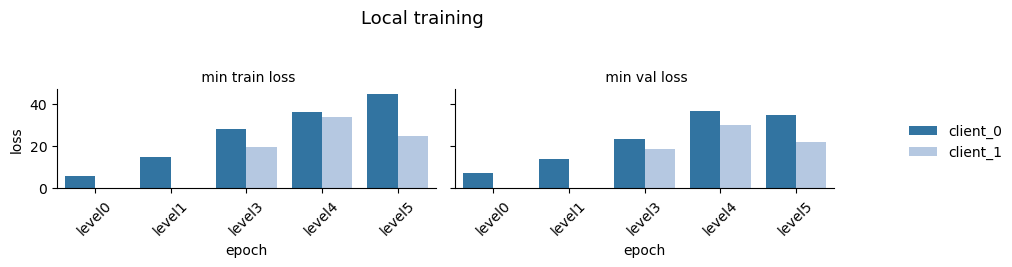

In [9]:
# plot each dataset in x axis, y is loss and hue is client 
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_local_min,
    col="type",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='client',
    palette='tab20'
)
# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" min {col_name} loss")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# legend
g._legend.set_loc("center left")
# title
# y axis log
plt.tight_layout()
plt.show()

In [10]:
# average loss across clients for each dataset
df_local_avg = df_local_min[["level", "type", "loss"]].groupby(["level", "type"]).mean().reset_index()
df_local_avg["dummy"] = 0

<Figure size 1000x300 with 0 Axes>

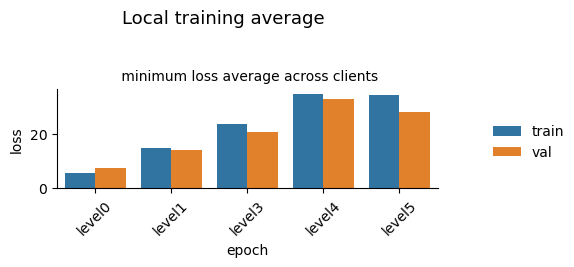

In [11]:
# plot each dataset in x axis, y is loss and hue is client 
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_local_avg,
    col="dummy",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='type',
    palette='tab10'
)
# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" minimum loss average across clients")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training average", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# legend
g._legend.set_loc("center left")
# title
# y axis log
plt.tight_layout()
plt.show()

In [12]:
df_local

,epoch,train_mse,val_mse,nodesolves,client,run_id,dataset_name,loss,type
0,0,0.001568,0.001906,132798,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,10.381877,train
1,21,0.001406,0.001763,132798,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,7.788983,val
2,20,0.001403,0.001745,132798,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,7.801334,val
3,19,0.001401,0.001739,132798,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,7.939360,val
4,17,0.001415,0.001743,132798,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level0_iid,8.237478,val
...,...,...,...,...,...,...,...,...,...
395,10,0.008609,0.006316,6500,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,36.096160,val
396,9,0.008744,0.006457,6500,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,36.802843,val
397,8,0.009673,0.007363,6500,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,40.756889,val
398,21,0.008269,0.006030,6500,client_0,25_epochs_lr_0.001-batchsize_32_clipping_False...,level5_temporal,34.705559,val


<Figure size 1000x300 with 0 Axes>

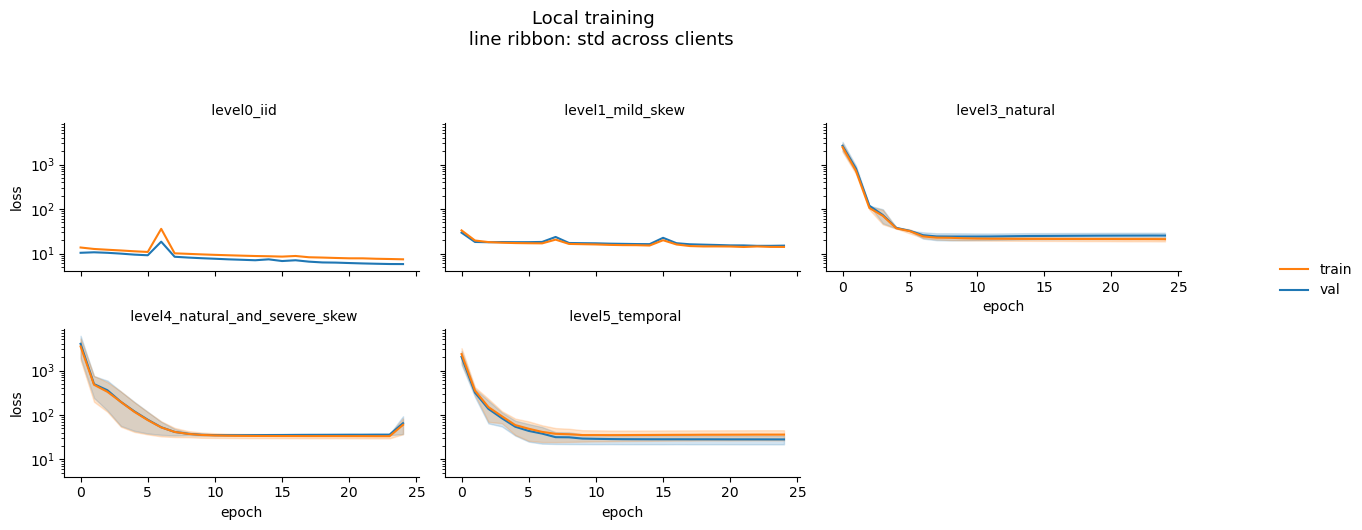

In [13]:
# fig size
plt.figure(figsize=(10, 3))


# Create FacetGrid
g = sns.FacetGrid(
    df_local,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True,
    col_wrap=3  # Adjust this to control the number of columns in the grid
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='epoch',
    y='loss',
    hue='type',
    markers=True,
    palette='tab10'
)

# Adjustments
g.set_axis_labels("epoch", "loss")
g.set_titles(" {col_name}")
#g.set(ylim=(0, None))

# add general title
g.fig.suptitle("Local training  \n line ribbon: std across clients", fontsize=13, y=1.05)

# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# y axis log
plt.yscale('log')


plt.tight_layout()
plt.show()

# Federated training

In [20]:
####################################
#     Federated training results
####################################

result_json = glob.glob(f"../{res_folder}/**/federated_training/**/**/**/results.json", recursive=True)
result_json = list(set(result_json))
result_json

df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
for file in result_json:
    df_centralized_evaluate_temp, df_federated_evaluate_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
# remove string ecg_physionet from dataset_name in df
df["dataset_name"] = df["dataset_name"].str.replace("ecg_physionet_", "")
# sort by dataset_name
df = df.sort_values(by=["dataset_name"]).reset_index(drop=True)
df_federated = df


/scratch/ipykernel_1897811/2254290233.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_centralized_evaluate, df_federated_evaluate])


<Figure size 1000x300 with 0 Axes>

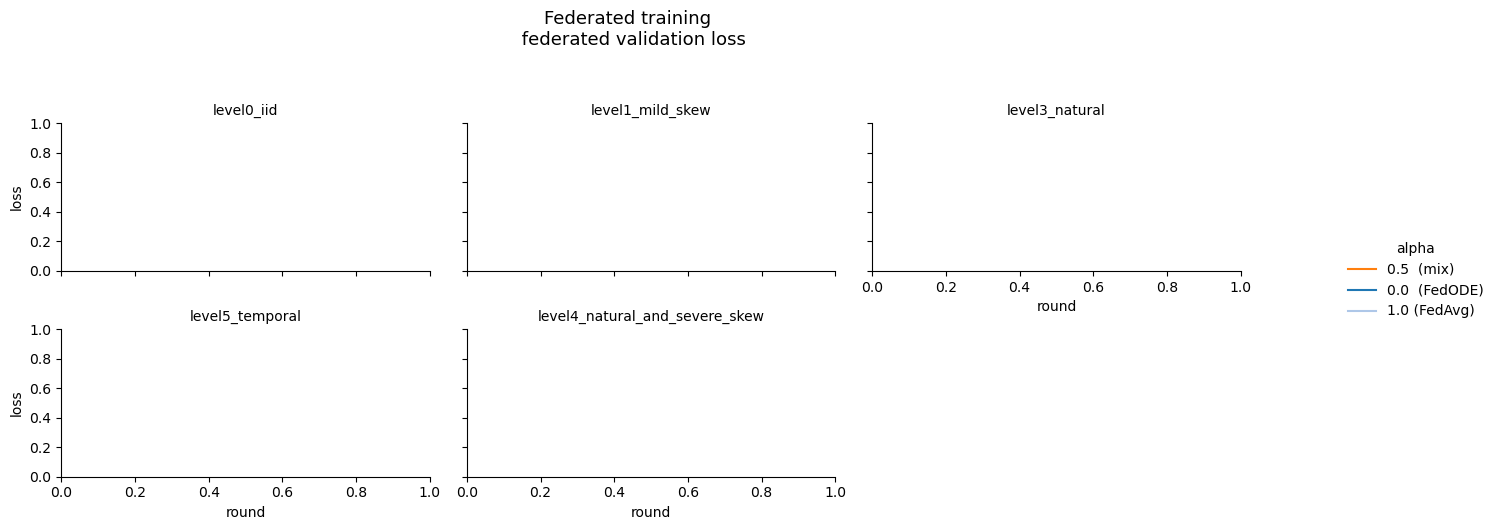

In [21]:
loss_df = df[df['type'].isin(["centralized", "federated"])]
loss_df = loss_df[loss_df["type"] == "federated"]

# sort dataset_name by given order
dataset_order = ['level0_iid', 'level1_mild_skew', 'level3_natural',"level5_temporal",
       'level4_natural_and_severe_skew']
loss_df['dataset_name'] = pd.Categorical(loss_df['dataset_name'], categories=dataset_order, ordered=True)

# add to leged is alpha is 0.0 fedODE 
loss_df['alpha'] = loss_df['alpha'].astype(str)
loss_df['alpha'] = loss_df['alpha'].replace({'0.0': '0.0  (FedODE)', '0.5': '0.5  (mix)', '1.0': '1.0 (FedAvg)'})

# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True,
    col_wrap=3  # Adjust this to control the number of columns in the grid
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='alpha',
    markers=True,
    palette='tab20'
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles("alpha {col_name}")
# add row_titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(ylim=(0, None))
# add general title
g.fig.suptitle("Federated training \n federated validation loss", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# plot the legend of plot

plt.tight_layout()
plt.show()

# Training loss within each client

In [73]:
result_json_client = glob.glob(f"../{res_folder}/**/federated_training/**/**/**/results_0.json", recursive=True)
result_json_client = list(set(result_json_client))

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level4_natural_and_severe_skew/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


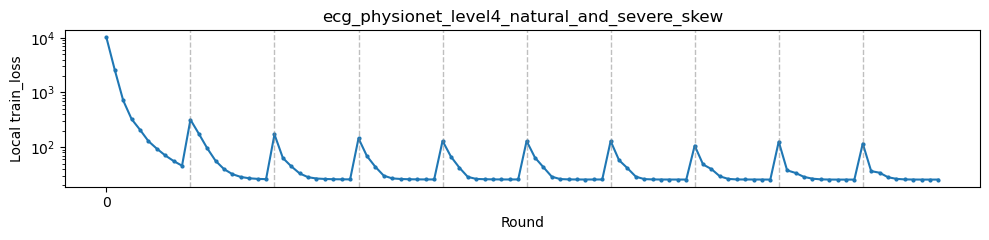

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level0_iid/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


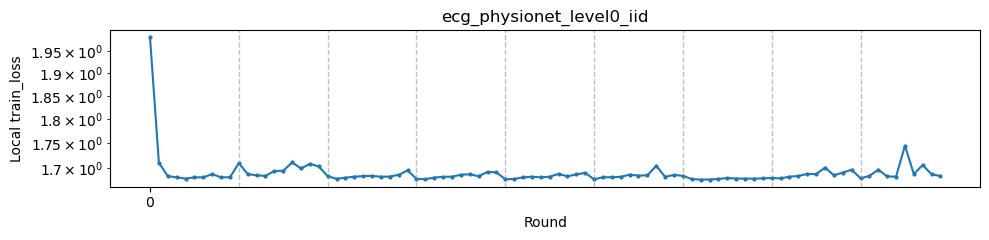

Loading meta data from ../results_ecg_simulation_new/ecg_physionet_level3_natural/federated_training/FedODE/10_rounds/rep_1-alpha_0.0-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_15_alpha_0.0/federated_outputs/meta.csv


/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/lib/plot_utils.py:346: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


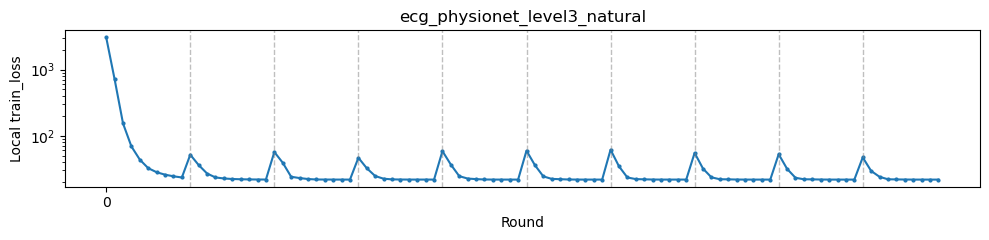

In [74]:
client_file = result_json_client[2]
for file in result_json_client:
    # if file name containes "alpha_0.5" 
    if "alpha_0.0" in file:
        plot_client_loss(file, type_loss = "train_loss", nrounds = 10, log = True)


In [75]:
df_summary_lambdas

,round,dataset_name,lambda,steps,alpha,client
0,1,level4_natural_and_severe_skew,0.500411,1826.0,0.5,1
1,2,level4_natural_and_severe_skew,0.501230,1838.0,0.5,0
2,3,level4_natural_and_severe_skew,0.500000,1820.0,0.5,1
3,4,level4_natural_and_severe_skew,0.500821,1832.0,0.5,0
4,5,level4_natural_and_severe_skew,0.499179,1820.0,0.5,1
...,...,...,...,...,...,...
191,6,level4_natural_and_severe_skew,0.500000,1820.0,1.0,1
192,7,level4_natural_and_severe_skew,0.500000,1820.0,1.0,0
193,8,level4_natural_and_severe_skew,0.500000,1826.0,1.0,1
194,9,level4_natural_and_severe_skew,0.500000,1838.0,1.0,1


# Investigate the number of ODE steps

In [76]:
df_summary_lambdas["level"] = df_summary_lambdas["dataset_name"].str.split("_").str[0].replace({"level0": "0", "level1": "1", "level2": "2", "level3": "3", "level4": "4", "level5": "5"})
df_summary_lambdas_0 = df_summary_lambdas[df_summary_lambdas["level"] == "0"]
df_summary_lambdas_1 = df_summary_lambdas[df_summary_lambdas["level"] == "1"]
df_summary_lambdas_2 = df_summary_lambdas[df_summary_lambdas["level"] == "2"]
df_summary_lambdas_3 = df_summary_lambdas[df_summary_lambdas["level"] == "3"]
df_summary_lambdas_4 = df_summary_lambdas[df_summary_lambdas["level"] == "4"]
df_summary_lambdas_5 = df_summary_lambdas[df_summary_lambdas["level"] == "5"]

<Figure size 1000x300 with 0 Axes>

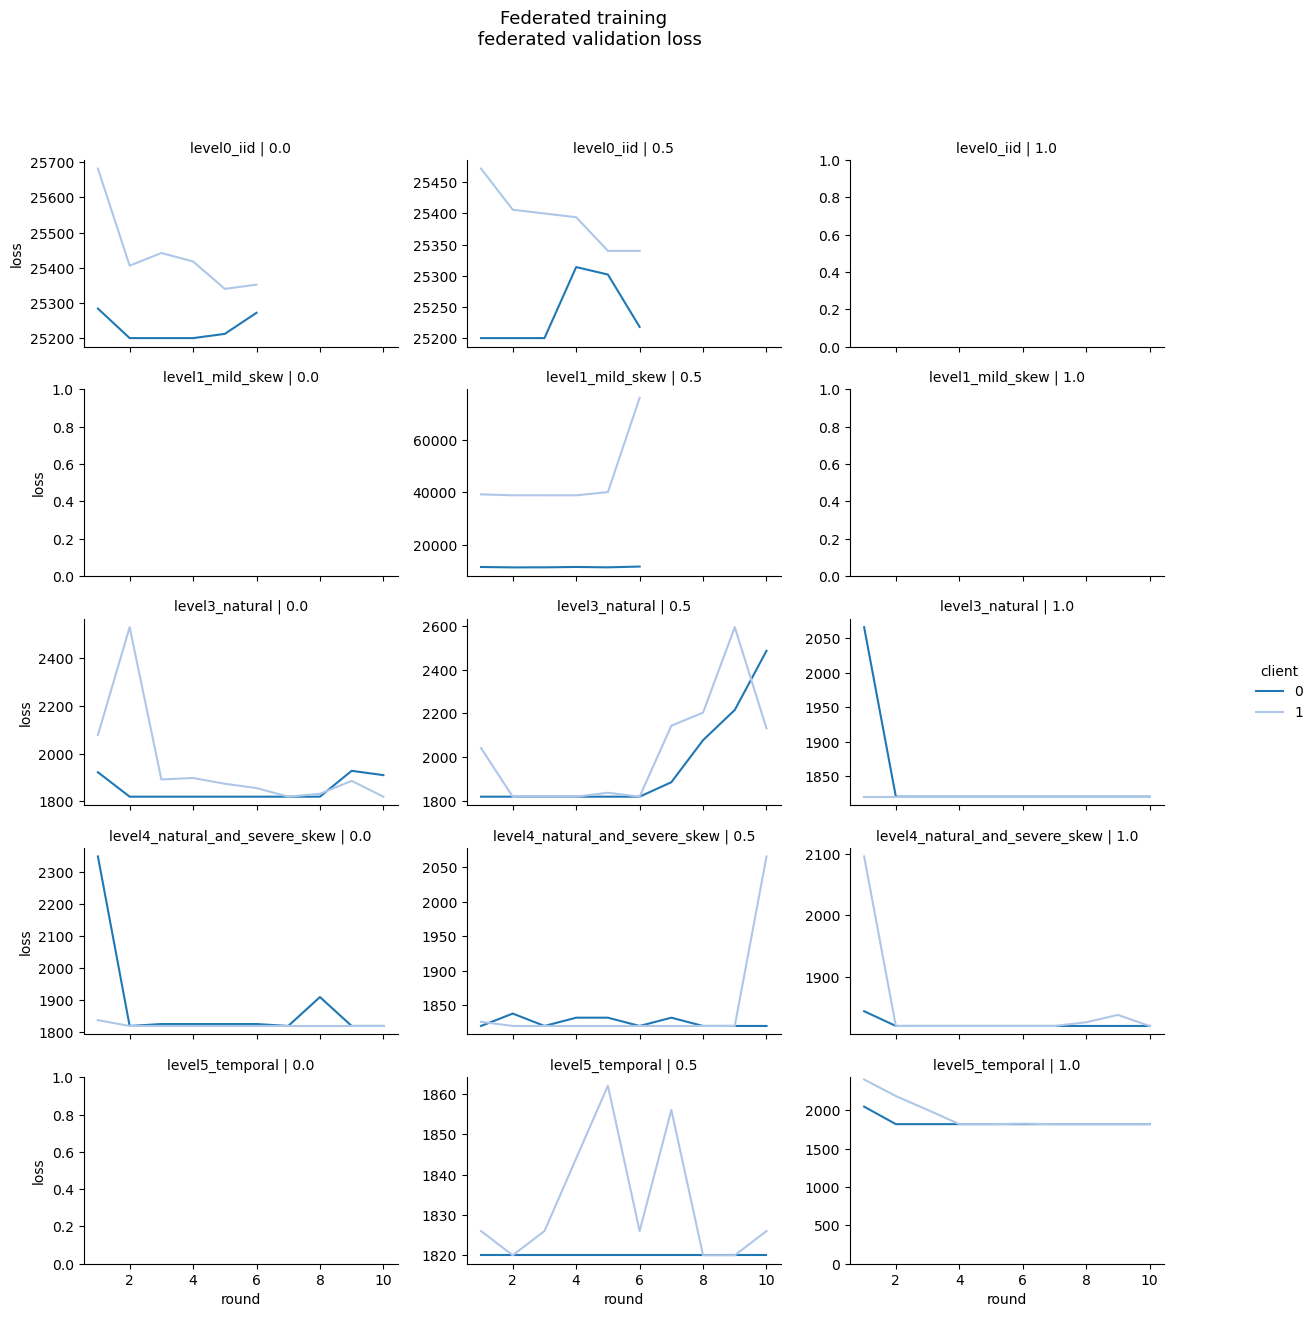

In [77]:
# sort dataset_name by alphabetical order
df_summary_lambdas = df_summary_lambdas.sort_values(by="dataset_name").reset_index(drop=True)

# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas,
    col="alpha",
    row="dataset_name",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=False) # Adjust this to control the number of columns in the grid)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='steps',
    hue='client',
    markers=True,
    palette='tab20'  # Use a colorblind-friendly palette
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles("client {col_name}")
# add row_titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(ylim=(0, None))
# add general title
g.fig.suptitle("Federated training \n federated validation loss", fontsize=13, y=1.05)
# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# plot the legend of plot
# y starts at 0
plt.ylim(0, None)
# y log scale
plt.tight_layout()
plt.show()

In [78]:
#df_centralized_min and df_local_min group by id 
df_centralized_min = df_centralized_min.rename(columns={"train_loss": "train_loss_min", "val_loss": "val_loss_min"})
# remove __ from dataset_name
df_centralized_min["level"] = df_centralized_min["dataset_name"].str.split("_").str[0]
# remove __ from dataset_name
# separate validation and training loss
df_cen_train = df_centralized_min[["level", "train_loss_min"]].rename(columns={"train_loss_min": "loss"})
df_cen_val = df_centralized_min[["level", "val_loss_min"]].rename(columns={"val_loss_min": "loss"})
df_cen_train["type"] = "train"
df_cen_val["type"] = "val"
df_centralized_min = pd.concat([df_cen_train, df_cen_val])
df_centralized_min["training_type"] = "centralized"
df_local_avg["training_type"] = "local"
# remove dummy column
df_local_avg = df_local_avg.drop(columns=["dummy"])
df_centralized_min = df_centralized_min.drop(columns=["training_type"])
df_local_avg = df_local_avg.drop(columns=["training_type"])
df_federated["level"] = df_federated["dataset_name"].str.split("_").str[0]
df_federated_min = df_federated[["level", "round", "loss", "type", "alpha"]] 
df_federated_min = df_federated_min[df_federated_min["type"] == "federated"]
# now keep the minimum loss for each dataset_name and alpha
df_federated_min = df_federated_min.groupby(["level", "alpha", "type"]).min().reset_index()
df_federated_min = df_federated_min.rename(columns={"loss": "loss_min"})
df_federated_min["training_type"] = "federated"
df_federated_min["type"] = "val"

# Summarize table with best loss 

In [94]:
# merge df_centralized_min and df_local_avg by level, type
# drop training type column from df_centralized_min and df_local_avg

df_combined = pd.merge(df_centralized_min, df_local_avg, on=["level", "type"], how="outer", suffixes=('_cen', '_local'))
df_combined = pd.merge(df_combined, df_federated_min, on=["level", "type"], how="outer")
df_combined
# reorder columns level, type, loss_cen, loss_local
df_combined = df_combined[["level", "type", "alpha", "loss_cen", "loss_local", "loss_min"]]
df_combined = df_combined.rename(columns={"loss_min": "loss_fed"})
# sort by level, type, alpha
df_combined = df_combined.sort_values(by=["level", "type", "alpha"]).reset_index(drop=True)
# rename columns

df_combined_train = df_combined[df_combined["type"] == "train"]
df_combined_val = df_combined[df_combined["type"] == "val"]
# order by level
df_combined_train = df_combined_train.sort_values(by=["level", "alpha"]).reset_index(drop=True)
# rename loss_min to skasdlsajjdf_combined_val
df_combined_val_0 = df_combined_val[df_combined_val["alpha"] == 0.0]
df_combined_val_1 = df_combined_val[df_combined_val["alpha"] == 1.0]

 # order by level


In [115]:
df_combined_val

df_combined_cen = df_combined_val.copy()
df_combined_cen["loss"] = df_combined_cen["loss_cen"]
df_combined_cen["loss_type"] = "centralized"
df_combined_cen.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)

df_combined_local = df_combined_val.copy()
df_combined_local["loss"] = df_combined_local["loss_local"]
df_combined_local["loss_type"] = "local"
df_combined_local.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)

df_combined_fed = df_combined_val.copy()
df_combined_fed["loss"] = df_combined_fed["loss_fed"]
df_combined_fed["loss_type"] = "federated"
df_combined_fed.drop(columns=["loss_cen", "loss_local", "loss_fed"], inplace=True)
# concatenate all dataframes
df_combined_all = pd.concat([df_combined_cen, df_combined_local, df_combined_fed])
# sort by level, loss_type


categories = ['centralized', 'local', 'federated']
df_combined_all['loss_type'] = pd.Categorical(df_combined_all['loss_type'], categories=categories, ordered=True)
df_combined_all["level"] = df_combined_all["level"].str.replace("level", "").astype(int)
# sort by level, loss_type
df_combined_all = df_combined_all.sort_values(by=["level"]).reset_index(drop=True)


In [116]:
df_combined_all

,level,type,alpha,loss,loss_type
0,0,val,0.0,6.930001,centralized
1,0,val,0.5,6.930001,centralized
2,0,val,0.5,13.667106,federated
3,0,val,0.0,12.764309,federated
4,0,val,0.0,11.446324,local
5,0,val,0.5,11.446324,local
6,1,val,0.5,6.010493,centralized
7,1,val,0.5,17.824161,federated
8,1,val,0.5,13.366833,local
9,2,val,NaN,NaN,centralized


<Figure size 1000x500 with 0 Axes>

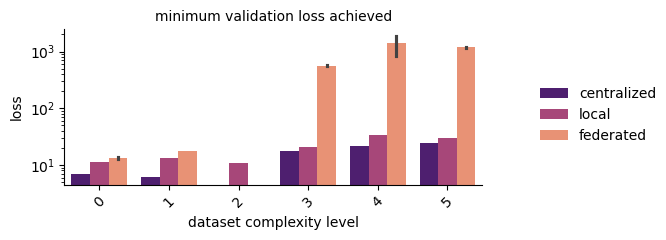

In [126]:


# plot barplot 
plt.figure(figsize=(10, 5))
# Create FacetGrid
g = sns.FacetGrid(
    df_combined_all,
    col="type",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
) 
# Map the barplot onto the grid
g.map_dataframe(
    sns.barplot,
    x='level',
    y='loss',
    hue='loss_type',
    palette='magma'
)
# Adjustments
g.set_axis_labels("dataset complexity level", "loss")
g.set_titles("minimum validation loss achieved")
#g.set(ylim=(0, None))   
# add general title
# Move legend outside
g.add_legend(title ="")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
# make x axis 45 degrees
g.set_xticklabels(rotation=45)
# y axis log
plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot latent dimension

Getting data min and max devices:  cpu


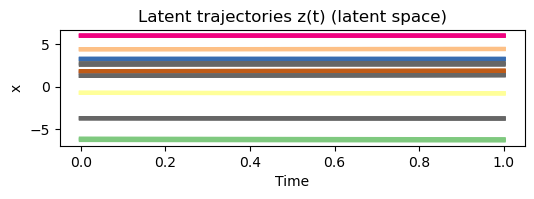

In [80]:
n_traj_to_show = 3
filtered_dataset = c0[10:40]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    # for dim_to_show in range(attr_names_filtered.shape[0]):
    #     name = attr_names_filtered[dim_to_show]
    ax_traj = []
    fig, ax_traj = plt.subplots(1, 1)
    fig.set_size_inches(6, 1.5)
    max_y = max(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
        reconstructions[:,:,dim_to_show].cpu().numpy().max())
    min_y = min(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
        reconstructions[:,:,dim_to_show].cpu().numpy().min())
    
    cmap = plt.colormaps['Set1']

    latent_traj = info["latent_traj"][0,:n_traj_to_show]
    # shape before permute: [1, n_tp, n_latent_dims]

    cmap = plt.colormaps['Accent']
    n_latent_dims = latent_traj.size(-1)

    custom_labels = {}
    for i in range(n_latent_dims):
        col = cmap(i)
        plot_trajectories(ax_traj, latent_traj, time_steps_to_predict, 
            title="Latent trajectories z(t) (latent space)", dim_to_show = i, color = col, 
            marker = '', add_to_plot = True,
            linewidth = 3)
            #custom_labels['dim ' + str(i)] = Line2D([0], [0], color=col)

        #ax_traj.set_ylabel("z")
        #ax_traj.set_title("Latent trajectories z(t) (latent space)", pad = 20)
        #ax_traj.legend(custom_labels.values(), custom_labels.keys(), loc = 'lower left')
plt.show()